In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from optuna.pruners import MedianPruner
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

/home/alfath/Documents/Kuliah/Bengkel Koding/UAS/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# path lokasi file
file_path = "dataset.csv"

# Load dataset
df = pd.read_csv(file_path)

In [3]:
# Tampilkan 5 baris pertama
print("===== 5 Data Pertama =====")
display(df.head())

===== 5 Data Pertama =====


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Hilangkan fitur tidak penting
df = df.drop(columns=['customerID', 'gender'])
display(df.head())

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Ringkasan struktur data
print("\n===== Informasi Dataset =====")
df.info()

# Statistik deskriptif kolom numerik
print("\n===== Statistik Deskriptif =====")
display(df.describe())


===== Informasi Dataset =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyChar

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Konversi TotalCharges ke numerik, set errors='coerce' untuk handle non-numerik
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

print("\n===== Informasi Dataset =====")
df.info()

print("\n===== Statistik Deskriptif =====")
display(df.describe())


===== Informasi Dataset =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     7043 non-null   int64  
 1   Partner           7043 non-null   object 
 2   Dependents        7043 non-null   object 
 3   tenure            7043 non-null   int64  
 4   PhoneService      7043 non-null   object 
 5   MultipleLines     7043 non-null   object 
 6   InternetService   7043 non-null   object 
 7   OnlineSecurity    7043 non-null   object 
 8   OnlineBackup      7043 non-null   object 
 9   DeviceProtection  7043 non-null   object 
 10  TechSupport       7043 non-null   object 
 11  StreamingTV       7043 non-null   object 
 12  StreamingMovies   7043 non-null   object 
 13  Contract          7043 non-null   object 
 14  PaperlessBilling  7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyChar

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Cek jumlah data duplikat
duplicate_count = df.duplicated().sum()
print(f"Jumlah data duplikat: {duplicate_count}")

# Jika ada duplikat, hapus baris duplikat
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Data setelah penghapusan duplikat: {df.shape[0]} baris")
else:
    print("Tidak ada data duplikat yang perlu dihapus.")

Jumlah data duplikat: 41
Data setelah penghapusan duplikat: 7002 baris


===== Persentase Missing Value Tiap Kolom =====


,Missing Count,Missing Percent (%)
TotalCharges,11,0.157098
Partner,0,0.000000
SeniorCitizen,0,0.000000
Dependents,0,0.000000
tenure,0,0.000000
MultipleLines,0,0.000000
PhoneService,0,0.000000
OnlineSecurity,0,0.000000
OnlineBackup,0,0.000000
DeviceProtection,0,0.000000


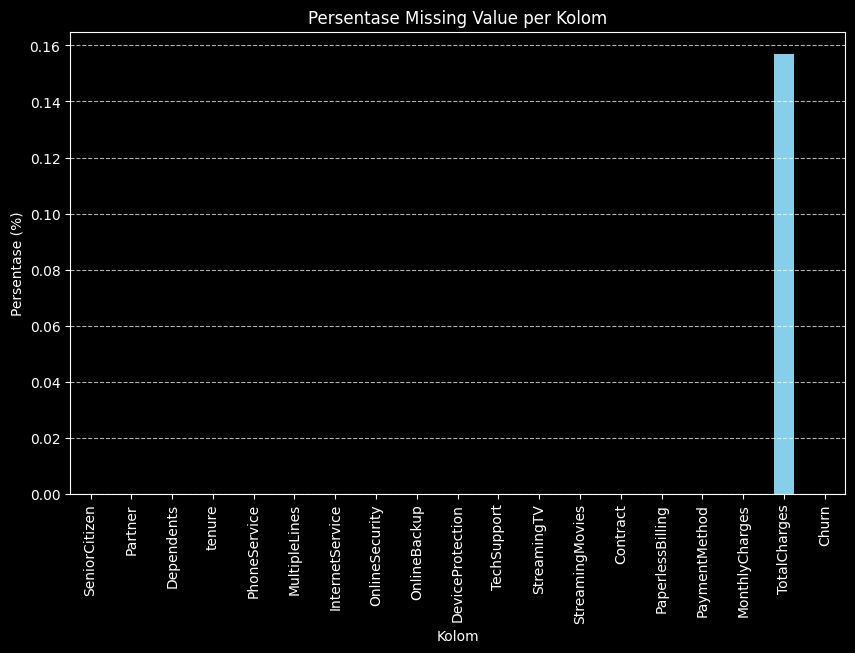

In [8]:
# Hitung jumlah dan persentase missing value
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100

# Buat DataFrame baru agar lebih mudah dibaca
missing_df = pd.DataFrame({
    'Missing Count': missing_count,
    'Missing Percent (%)': missing_percent
}).sort_values(by='Missing Percent (%)', ascending=False)

print("===== Persentase Missing Value Tiap Kolom =====")
display(missing_df)

# Visualisasi dalam diagram batang
plt.figure(figsize=(10,6))
missing_percent.plot(kind='bar', color='skyblue')
plt.title("Persentase Missing Value per Kolom")
plt.ylabel("Persentase (%)")
plt.xlabel("Kolom")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

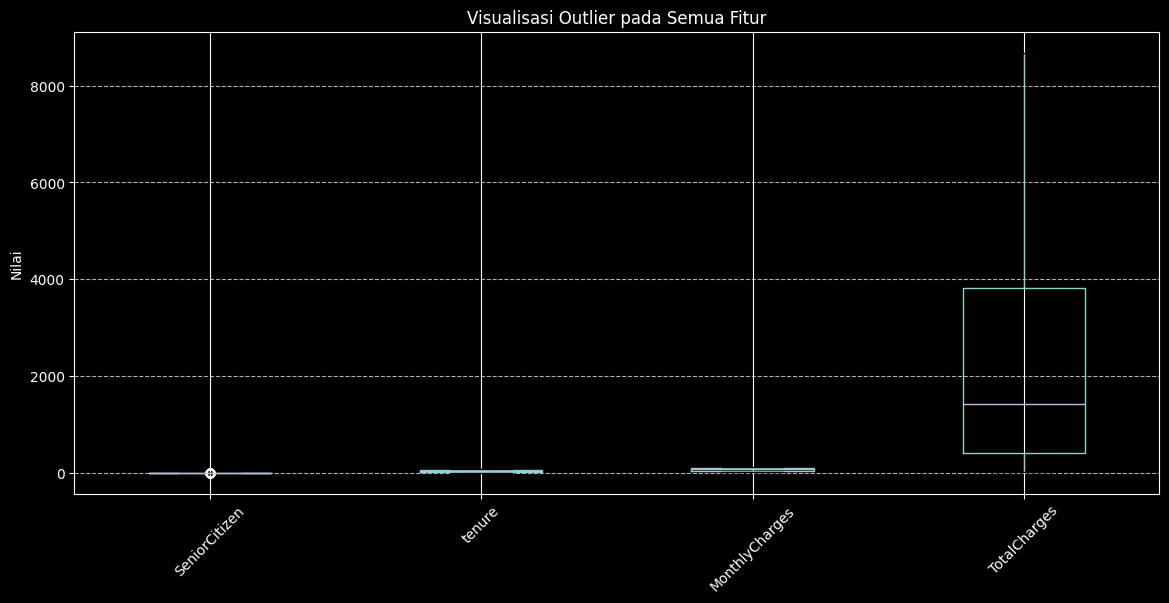

In [9]:
# Pilih semua fitur
features_outlier = df.select_dtypes(include='number').columns

# Plot boxplot untuk semua fitur numerik
plt.figure(figsize=(14, 6))
df[features_outlier].boxplot()
plt.title("Visualisasi Outlier pada Semua Fitur")
plt.ylabel("Nilai")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

===== Distribusi Target (Churn) =====
Churn
No     5155
Yes    1847
Name: count, dtype: int64

Persentase Tiap Kelas:
Churn
No     73.621822
Yes    26.378178
Name: proportion, dtype: float64


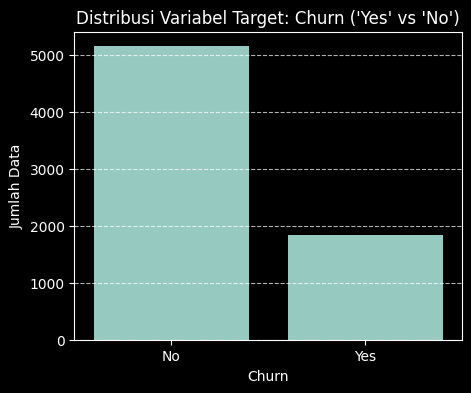

In [10]:
# Cek jumlah kelas
print("===== Distribusi Target (Churn) =====")
print(df['Churn'].value_counts())
print("\nPersentase Tiap Kelas:")
print(df['Churn'].value_counts(normalize=True) * 100)

# Visualisasi distribusi target
plt.figure(figsize=(5,4))
sns.countplot(data=df, x='Churn')
plt.title("Distribusi Variabel Target: Churn ('Yes' vs 'No')")
plt.xlabel("Churn")
plt.ylabel("Jumlah Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

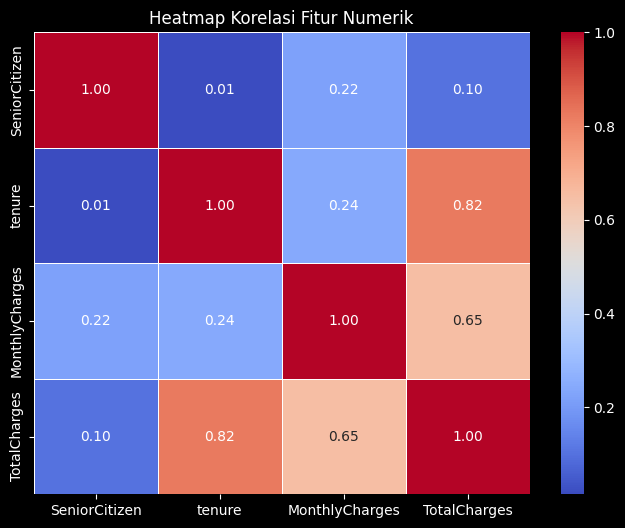

In [11]:
# Pilih hanya fitur numerik
numerical_features = df.select_dtypes(include='number').columns

# Hitung korelasi
corr_matrix = df[numerical_features].corr()

# Tampilkan heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

In [12]:
# Tentukan fitur (X) dan label (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1})

# Split data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [13]:
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categoric_cols)
])

In [14]:
# Inisialisasi model
svm = SGDClassifier(loss="hinge", random_state=42)
lr  = SGDClassifier(loss="log_loss", random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

voting = VotingClassifier(
    estimators=[
        ('svm', svm),
        ('lr', lr),
        ('dt', dt)
    ],
    voting='hard'
)

In [15]:
lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)
])

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

voting_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting)
])

# Training model
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
voting_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains sp

===== Logistic Regression =====
              precision    recall  f1-score   support

          No       0.90      0.72      0.80      1031
         Yes       0.50      0.77      0.60       370

    accuracy                           0.73      1401
   macro avg       0.70      0.75      0.70      1401
weighted avg       0.79      0.73      0.75      1401



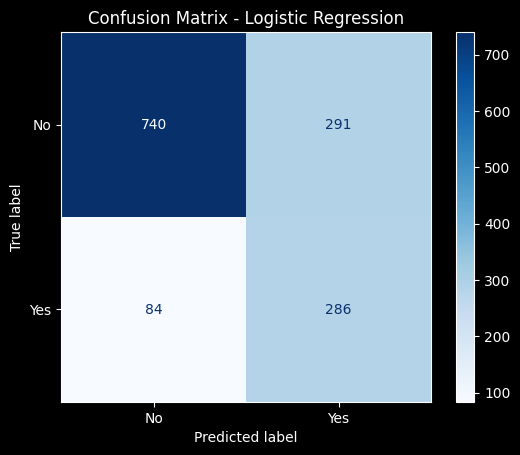

===== Random Forest =====
              precision    recall  f1-score   support

          No       0.82      0.86      0.84      1031
         Yes       0.55      0.46      0.50       370

    accuracy                           0.76      1401
   macro avg       0.68      0.66      0.67      1401
weighted avg       0.75      0.76      0.75      1401



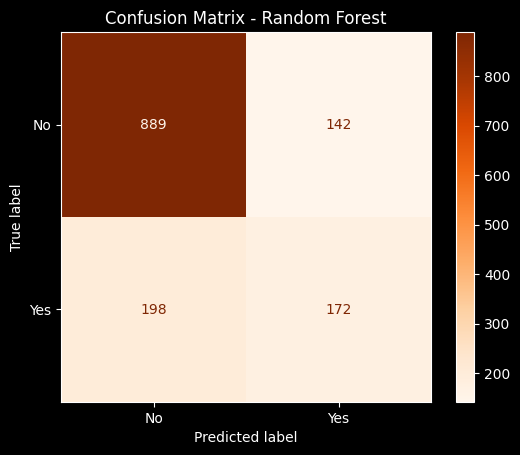

===== Voting =====
              precision    recall  f1-score   support

          No       0.87      0.81      0.84      1031
         Yes       0.55      0.67      0.61       370

    accuracy                           0.77      1401
   macro avg       0.71      0.74      0.72      1401
weighted avg       0.79      0.77      0.78      1401



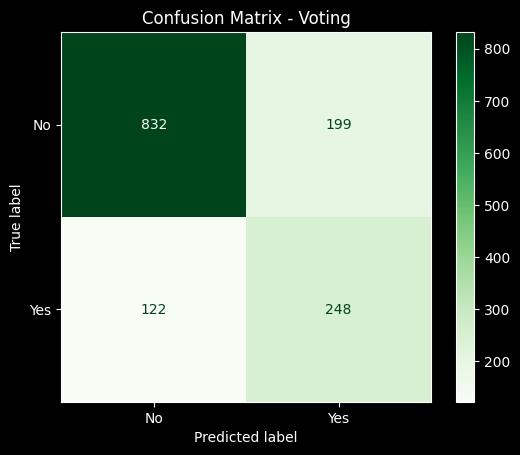

In [16]:
# Prediksi untuk masing-masing model
y_pred_lr = lr_pipe.predict(X_test)
y_pred_rf = rf_pipe.predict(X_test)
y_pred_voting = voting_pipe.predict(X_test)

# Evaluasi Logistic Regression
print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr, target_names=['No', 'Yes']))

cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Evaluasi Random Forest
print("===== Random Forest =====")
print(classification_report(y_test, y_pred_rf, target_names=['No', 'Yes']))

cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=['No', 'Yes']).plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Evaluasi Voting
print("===== Voting =====")
print(classification_report(y_test, y_pred_voting, target_names=['No', 'Yes']))

cm_voting = confusion_matrix(y_test, y_pred_voting)
ConfusionMatrixDisplay(cm_voting, display_labels=['No', 'Yes']).plot(cmap='Greens')
plt.title("Confusion Matrix - Voting")
plt.show()

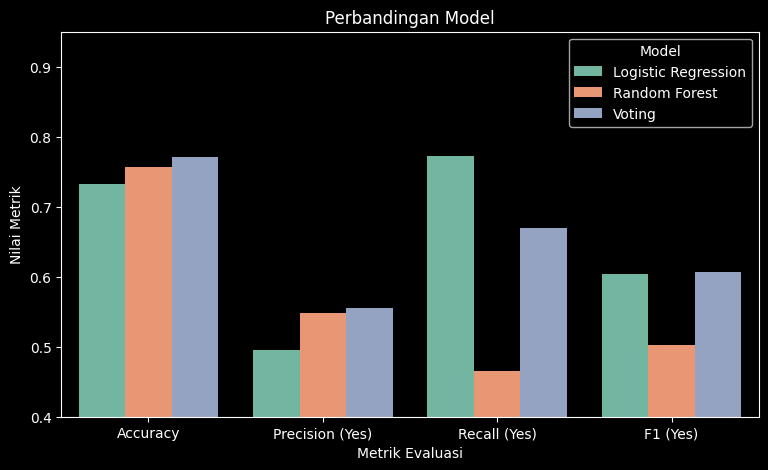

In [17]:
# Hitung metrik utama untuk Logistic Regression
acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr, pos_label=1)
recall_lr = recall_score(y_test, y_pred_lr, pos_label=1)
f1_lr = f1_score(y_test, y_pred_lr, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, pos_label=1)
recall_rf = recall_score(y_test, y_pred_rf, pos_label=1)
f1_rf = f1_score(y_test, y_pred_rf, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_voting = accuracy_score(y_test, y_pred_voting)
prec_voting = precision_score(y_test, y_pred_voting, pos_label=1)
recall_voting = recall_score(y_test, y_pred_voting, pos_label=1)
f1_voting = f1_score(y_test, y_pred_voting, pos_label=1)

# Buat DataFrame perbandingan metrik
df_baseline = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting'],
    'Accuracy': [acc_lr, acc_rf, acc_voting],
    'Precision (Yes)': [prec_lr, prec_rf, prec_voting],
    'Recall (Yes)': [recall_lr, recall_rf, recall_voting],
    'F1 (Yes)': [f1_lr, f1_rf, f1_voting]
})

# Ubah format ke long untuk visualisasi seaborn
baseline_melt = df_baseline.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=baseline_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Perbandingan Model')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

In [18]:
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_ = {}
        self.upper_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in X.columns:
            self.lower_[col] = X[col].quantile(self.lower_quantile)
            self.upper_[col] = X[col].quantile(self.upper_quantile)
        return self

    def transform(self, X):
        X = pd.DataFrame(X).copy()
        for col in X.columns:
            X[col] = np.where(X[col] < self.lower_[col], self.lower_[col], X[col])
            X[col] = np.where(X[col] > self.upper_[col], self.upper_[col], X[col])
        return X.values

In [19]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('winsor', Winsorizer(lower_quantile=0.01, upper_quantile=0.99)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categoric_cols)
])

In [20]:
svm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', 'passthrough'),
    ('classifier', svm)
])

lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', 'passthrough'),
    ('classifier', lr)
])

dt_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', 'passthrough'),
    ('classifier', dt)
])

rf_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', 'passthrough'),
    ('classifier', rf)
])

voting_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', 'passthrough'),
    ('classifier', voting)
])

# Training model
lr_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)
voting_pipe.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('feature_selection', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

===== Logistic Regression =====
              precision    recall  f1-score   support

          No       0.91      0.74      0.81      1031
         Yes       0.52      0.79      0.63       370

    accuracy                           0.75      1401
   macro avg       0.71      0.76      0.72      1401
weighted avg       0.80      0.75      0.76      1401



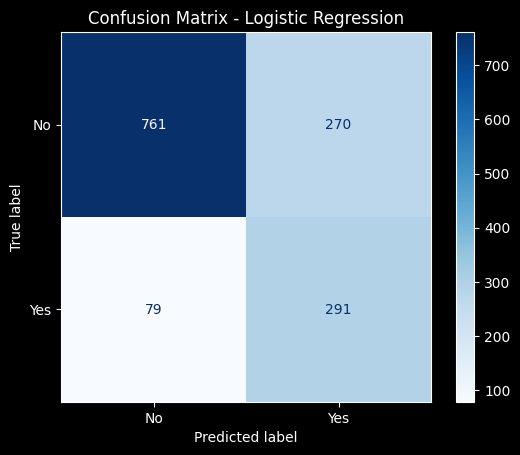

===== Random Forest =====
              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1031
         Yes       0.63      0.48      0.55       370

    accuracy                           0.79      1401
   macro avg       0.73      0.69      0.70      1401
weighted avg       0.78      0.79      0.78      1401



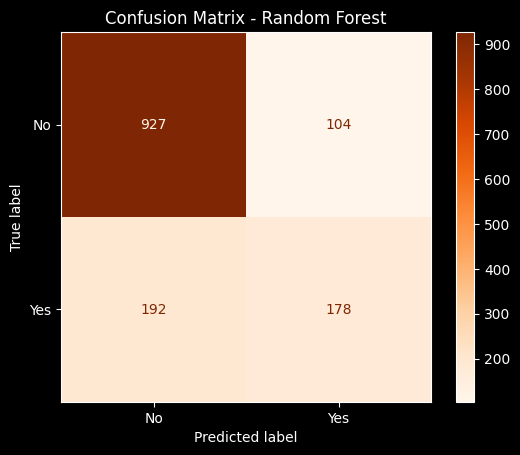

===== Voting =====
              precision    recall  f1-score   support

          No       0.86      0.85      0.86      1031
         Yes       0.60      0.62      0.61       370

    accuracy                           0.79      1401
   macro avg       0.73      0.74      0.73      1401
weighted avg       0.79      0.79      0.79      1401



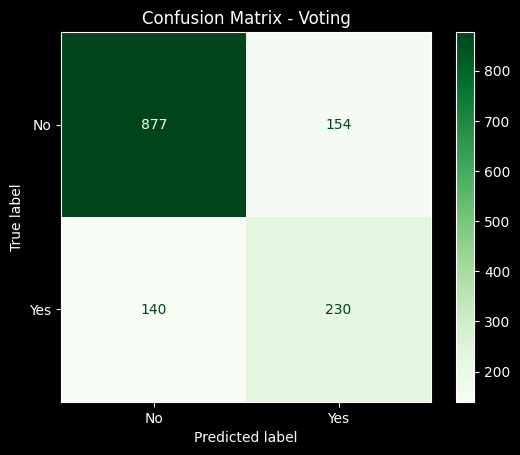

In [21]:
# Prediksi untuk masing-masing model
y_pred_lr_clean = lr_pipe.predict(X_test)
y_pred_rf_clean = rf_pipe.predict(X_test)
y_pred_voting_clean = voting_pipe.predict(X_test)

# Evaluasi Logistic Regression
print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr_clean, target_names=['No', 'Yes']))

cm_lr_clean = confusion_matrix(y_test, y_pred_lr_clean)
ConfusionMatrixDisplay(cm_lr_clean, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Evaluasi Random Forest
print("===== Random Forest =====")
print(classification_report(y_test, y_pred_rf_clean, target_names=['No', 'Yes']))

cm_rf_clean = confusion_matrix(y_test, y_pred_rf_clean)
ConfusionMatrixDisplay(cm_rf_clean, display_labels=['No', 'Yes']).plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Evaluasi Voting
print("===== Voting =====")
print(classification_report(y_test, y_pred_voting_clean, target_names=['No', 'Yes']))

cm_voting_clean = confusion_matrix(y_test, y_pred_voting_clean)
ConfusionMatrixDisplay(cm_voting_clean, display_labels=['No', 'Yes']).plot(cmap='Greens')
plt.title("Confusion Matrix - Voting")
plt.show()

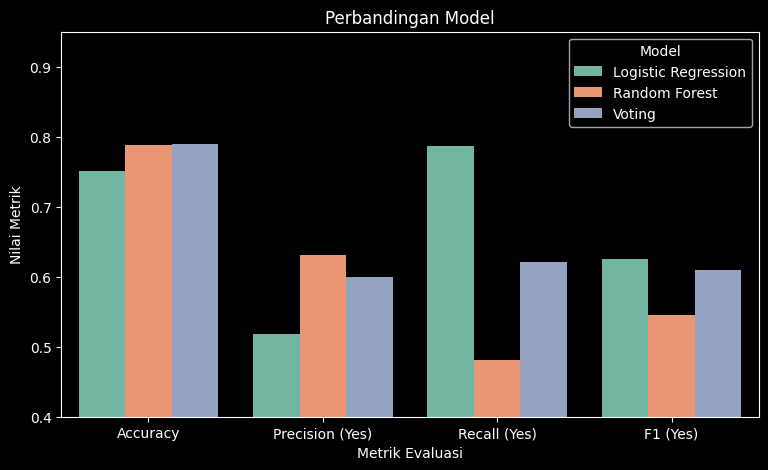

In [22]:
# Hitung metrik utama untuk Logistic Regression
acc_lr_clean = accuracy_score(y_test, y_pred_lr_clean)
prec_lr_clean = precision_score(y_test, y_pred_lr_clean, pos_label=1)
recall_lr_clean = recall_score(y_test, y_pred_lr_clean, pos_label=1)
f1_lr_clean = f1_score(y_test, y_pred_lr_clean, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_rf_clean = accuracy_score(y_test, y_pred_rf_clean)
prec_rf_clean = precision_score(y_test, y_pred_rf_clean, pos_label=1)
recall_rf_clean = recall_score(y_test, y_pred_rf_clean, pos_label=1)
f1_rf_clean = f1_score(y_test, y_pred_rf_clean, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_voting_clean = accuracy_score(y_test, y_pred_voting_clean)
prec_voting_clean = precision_score(y_test, y_pred_voting_clean, pos_label=1)
recall_voting_clean = recall_score(y_test, y_pred_voting_clean, pos_label=1)
f1_voting_clean = f1_score(y_test, y_pred_voting_clean, pos_label=1)

# Buat DataFrame perbandingan metrik
df_clean = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting'],
    'Accuracy': [acc_lr_clean, acc_rf_clean, acc_voting_clean],
    'Precision (Yes)': [prec_lr_clean, prec_rf_clean, prec_voting_clean],
    'Recall (Yes)': [recall_lr_clean, recall_rf_clean, recall_voting_clean],
    'F1 (Yes)': [f1_lr_clean, f1_rf_clean, f1_voting_clean]
})

# Ubah format ke long untuk visualisasi seaborn
clean_melt = df_clean.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=clean_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Perbandingan Model')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

In [23]:
rf_model = rf_pipe.named_steps['classifier']

preprocessor_fitted = rf_pipe.named_steps['preprocessor']

num_features = numeric_cols

cat_encoder = preprocessor_fitted.named_transformers_['cat'] \
                                  .named_steps['encoder']
cat_features = cat_encoder.get_feature_names_out(categoric_cols)

feature_names = np.concatenate([num_features, cat_features])

importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

display(feature_importance_df)

,Feature,Importance
3,TotalCharges,0.167483
2,MonthlyCharges,0.151036
1,tenure,0.148101
34,Contract_Month-to-month,0.049347
16,OnlineSecurity_No,0.031431
25,TechSupport_No,0.029926
41,PaymentMethod_Electronic check,0.029014
14,InternetService_Fiber optic,0.024706
0,SeniorCitizen,0.019712
36,Contract_Two year,0.019037


In [24]:
rf_selector = SelectFromModel(
    estimator=rf,
    threshold=0.01
)

svm_pipe.set_params(feature_selection=rf_selector)
lr_pipe.set_params(feature_selection=rf_selector)
dt_pipe.set_params(feature_selection=rf_selector)
rf_pipe.set_params(feature_selection=rf_selector)
voting_pipe.set_params(feature_selection=rf_selector)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('feature_selection', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

In [25]:
# Repeated K-Fold 5x2
rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

In [26]:
# Objective function untuk Optuna
def objective_svm(trial):
    pos_weight = trial.suggest_float("pos_weight", 1.0, 12.5)
    
    # Hyperparameter tuning
    params = {
        "classifier__alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
        "classifier__learning_rate": trial.suggest_categorical("learning_rate", ["optimal", "adaptive"]),
        "classifier__penalty": trial.suggest_categorical("penalty", ["l2"]),
        "classifier__early_stopping": trial.suggest_categorical("early_stopping", [True]),
        "classifier__class_weight": {0: 1.0, 1: pos_weight},
    }
    svm_pipe.set_params(**params)
    
    # Cross-validation
    score = cross_val_score(
        svm_pipe, X_train, y_train,
        cv=rkf,
        scoring="f1",
        n_jobs=-1
    ).mean()
    
    return score

# Study Optuna
study_svm = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_svm.optimize(objective_svm, n_trials=100)

[I 2025-12-15 05:43:12,235] A new study created in memory with name: no-name-268cf745-e6c6-43c6-9964-dc93bef66ede
[I 2025-12-15 05:43:21,042] Trial 0 finished with value: 0.5372728179739938 and parameters: {'pos_weight': 8.293857846477557, 'alpha': 3.5198521149030516e-06, 'learning_rate': 'adaptive', 'penalty': 'l2', 'early_stopping': True}. Best is trial 0 with value: 0.5372728179739938.
[I 2025-12-15 05:43:25,332] Trial 1 finished with value: 0.5555141791918221 and parameters: {'pos_weight': 4.807567753905559, 'alpha': 9.314407110150008e-05, 'learning_rate': 'optimal', 'penalty': 'l2', 'early_stopping': True}. Best is trial 1 with value: 0.5555141791918221.
[I 2025-12-15 05:43:29,417] Trial 2 finished with value: 0.6124864207788937 and parameters: {'pos_weight': 3.066609126457744, 'alpha': 0.0029070817000655083, 'learning_rate': 'optimal', 'penalty': 'l2', 'early_stopping': True}. Best is trial 2 with value: 0.6124864207788937.
[I 2025-12-15 05:43:33,552] Trial 3 finished with value:

In [27]:
# Objective function untuk Optuna
def objective_lr(trial):
    pos_weight = trial.suggest_float("pos_weight", 1.0, 12.5)

    # Hyperparameter tuning
    params = {
        "classifier__alpha": trial.suggest_float("alpha", 1e-6, 1e-2, log=True),
        "classifier__learning_rate": trial.suggest_categorical("learning_rate", ["optimal", "adaptive"]),
        "classifier__max_iter": trial.suggest_int("max_iter", 1000, 5000, step=500),
        "classifier__penalty": trial.suggest_categorical("penalty", ["l2"]),
        "classifier__early_stopping": trial.suggest_categorical("early_stopping", [True]),
        "classifier__class_weight": {0: 1.0, 1: pos_weight},
    }
    lr_pipe.set_params(**params)
    
    # Cross-validation
    score = cross_val_score(
        lr_pipe, X_train, y_train,
        cv=rkf,
        scoring="f1",
        n_jobs=-1
    ).mean()
    
    return score

# Study Optuna
study_lr = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_lr.optimize(objective_lr, n_trials=100)

[I 2025-12-15 05:50:42,188] A new study created in memory with name: no-name-b1287055-3f1b-4049-80e1-73f3b6642283
[I 2025-12-15 05:50:46,592] Trial 0 finished with value: 0.5938083268220009 and parameters: {'pos_weight': 1.3664644745734429, 'alpha': 0.00026292790856966854, 'learning_rate': 'optimal', 'max_iter': 1500, 'penalty': 'l2', 'early_stopping': True}. Best is trial 0 with value: 0.5938083268220009.
[I 2025-12-15 05:50:51,320] Trial 1 finished with value: 0.6160109348091638 and parameters: {'pos_weight': 3.5103382825115848, 'alpha': 0.00046011415422462793, 'learning_rate': 'adaptive', 'max_iter': 4500, 'penalty': 'l2', 'early_stopping': True}. Best is trial 1 with value: 0.6160109348091638.
[I 2025-12-15 05:50:55,426] Trial 2 finished with value: 0.3464087292625649 and parameters: {'pos_weight': 1.2956672958508224, 'alpha': 3.2451611147041284e-05, 'learning_rate': 'optimal', 'max_iter': 4500, 'penalty': 'l2', 'early_stopping': True}. Best is trial 1 with value: 0.616010934809163

In [28]:
# Objective function untuk Optuna
def objective_dt(trial):
    pos_weight = trial.suggest_float("pos_weight", 1.0, 25.0)

    # Hyperparameter tuning
    params = {
        "classifier__max_depth": trial.suggest_int("max_depth", 3, 8),
        "classifier__min_samples_split": trial.suggest_int("min_samples_split", 5, 30),
        "classifier__min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "classifier__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "classifier__criterion": trial.suggest_categorical("criterion", ["gini"]),
        "classifier__class_weight": {0: 1.0, 1: pos_weight}
    }
    dt_pipe.set_params(**params)
    
    # Cross-validation
    score = cross_val_score(
        dt_pipe, X_train, y_train,
        cv=rkf,
        scoring="f1",
        n_jobs=-1
    ).mean()
    
    return score

# Study Optuna
study_dt = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_dt.optimize(objective_dt, n_trials=100)

[I 2025-12-15 05:58:23,210] A new study created in memory with name: no-name-e6bbc7ec-416e-4d63-9c8d-8ed76340709c
[I 2025-12-15 05:58:27,588] Trial 0 finished with value: 0.523895042757297 and parameters: {'pos_weight': 14.107154949984036, 'max_depth': 7, 'min_samples_split': 18, 'min_samples_leaf': 25, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.523895042757297.
[I 2025-12-15 05:58:31,827] Trial 1 finished with value: 0.5164390826376608 and parameters: {'pos_weight': 17.002826406579405, 'max_depth': 4, 'min_samples_split': 19, 'min_samples_leaf': 13, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.523895042757297.
[I 2025-12-15 05:58:36,230] Trial 2 finished with value: 0.590874492910497 and parameters: {'pos_weight': 3.6457137410344007, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 32, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 2 with value: 0.590874492910497.
[I 2025-12-15 05:58:40,276] Trial 3 

In [29]:
# Objective function untuk Optuna
def objective_rf(trial):
    pos_weight = trial.suggest_float("pos_weight", 1.0, 25.0)

    # Hyperparameter tuning
    params = {
        "classifier__n_estimators": trial.suggest_int("n_estimators", 200, 600, step=50),
        "classifier__max_depth": trial.suggest_int("max_depth", 5, 15),
        "classifier__min_samples_split": trial.suggest_int("min_samples_split", 10, 50),
        "classifier__min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 50),
        "classifier__max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "classifier__bootstrap": True,
        "classifier__class_weight": {0: 1.0, 1: pos_weight}
    }
    rf_pipe.set_params(**params)
    
    # Cross-validation
    score = cross_val_score(
        rf_pipe, X_train, y_train,
        cv=rkf,
        scoring="f1",
        n_jobs=-1
    ).mean()
    
    return score

# Study Optuna
study_rf = optuna.create_study(direction="maximize", pruner=MedianPruner())
study_rf.optimize(objective_rf, n_trials=100)

[I 2025-12-15 06:05:32,407] A new study created in memory with name: no-name-39995e0a-034d-48d1-a3d1-5aad6b99fffa
[I 2025-12-15 06:05:57,480] Trial 0 finished with value: 0.5436720867838657 and parameters: {'pos_weight': 19.78038952816602, 'n_estimators': 550, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.5436720867838657.
[I 2025-12-15 06:06:08,467] Trial 1 finished with value: 0.546797864673131 and parameters: {'pos_weight': 11.567898126686686, 'n_estimators': 250, 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 21, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.546797864673131.
[I 2025-12-15 06:06:31,380] Trial 2 finished with value: 0.5309381601176499 and parameters: {'pos_weight': 16.93652859027188, 'n_estimators': 550, 'max_depth': 9, 'min_samples_split': 42, 'min_samples_leaf': 38, 'max_features': 'log2'}. Best is trial 1 with value: 0.546797864673131.
[I 2025-12-15 06:06:52,202] Trial

In [30]:
best_params_svm = study_svm.best_trial.params.copy()
best_params_lr = study_lr.best_trial.params.copy()
best_params_dt = study_dt.best_trial.params.copy()
best_params_rf = study_rf.best_trial.params.copy()

print("Support Vector Machine Best Params:", best_params_svm) 
print("Logistic Regression Best Params:", best_params_lr) 
print("Decision Tree Best Params:", best_params_dt)
print("Random Forest Best Params:", best_params_rf)

Support Vector Machine Best Params: {'pos_weight': 2.037000755046742, 'alpha': 0.002507947059932772, 'learning_rate': 'adaptive', 'penalty': 'l2', 'early_stopping': True}
Logistic Regression Best Params: {'pos_weight': 1.8641688278907198, 'alpha': 0.00633993877665428, 'learning_rate': 'adaptive', 'max_iter': 1500, 'penalty': 'l2', 'early_stopping': True}
Decision Tree Best Params: {'pos_weight': 2.0551208855216068, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 28, 'max_features': None, 'criterion': 'gini'}
Random Forest Best Params: {'pos_weight': 2.5351722374454297, 'n_estimators': 200, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 'sqrt'}


In [31]:
svm_pos_weight = best_params_svm.pop("pos_weight")
svm_params = {k.replace("classifier__", ""): v for k, v in best_params_svm.items()}
svm_params["class_weight"] = {0: 1.0, 1: svm_pos_weight}

lr_pos_weight = best_params_lr.pop("pos_weight")
lr_params = {k.replace("classifier__", ""): v for k, v in best_params_lr.items()}
lr_params["class_weight"] = {0: 1.0, 1: lr_pos_weight}

dt_pos_weight = best_params_dt.pop("pos_weight")
dt_params = {k.replace("classifier__", ""): v for k, v in best_params_dt.items()}
dt_params["class_weight"] = {0: 1.0, 1: dt_pos_weight}

rf_pos_weight = best_params_rf.pop("pos_weight")
rf_params = {k.replace("classifier__", ""): v for k, v in best_params_rf.items()}
rf_params["class_weight"] = {0: 1.0, 1: rf_pos_weight}

In [32]:
# Inisialisasi model
svm_best = SGDClassifier(loss="hinge", random_state=42, **svm_params)
lr_best  = SGDClassifier(loss="log_loss", random_state=42, **lr_params)
dt_best = DecisionTreeClassifier(random_state=42, **dt_params)
rf_best = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_params)

voting_best = VotingClassifier(
    estimators=[
        ('svm', svm_best),
        ('lr', lr_best),
        ('dt', dt_best)
    ],
    voting='hard'
)

In [33]:
lr_pipe_best = lr_pipe.set_params(classifier=lr_best)
rf_pipe_best = rf_pipe.set_params(classifier=rf_best)
voting_pipe_best = voting_pipe.set_params(classifier=voting_best)

# Training model
lr_pipe_best.fit(X_train, y_train)
rf_pipe_best.fit(X_train, y_train)
voting_pipe_best.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('feature_selection', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

===== Logistic Regression =====
              precision    recall  f1-score   support

          No       0.88      0.81      0.84      1031
         Yes       0.57      0.70      0.63       370

    accuracy                           0.78      1401
   macro avg       0.73      0.76      0.74      1401
weighted avg       0.80      0.78      0.79      1401



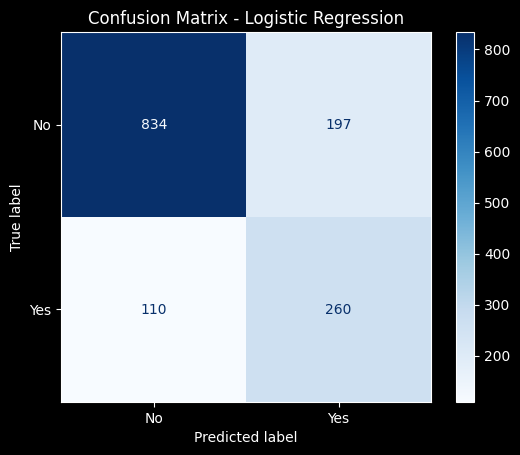

===== Random Forest =====
              precision    recall  f1-score   support

          No       0.91      0.78      0.84      1031
         Yes       0.56      0.77      0.65       370

    accuracy                           0.78      1401
   macro avg       0.73      0.78      0.74      1401
weighted avg       0.81      0.78      0.79      1401



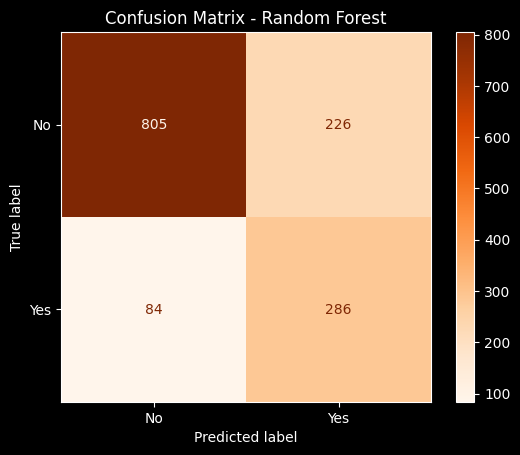

===== Voting =====
              precision    recall  f1-score   support

          No       0.90      0.78      0.84      1031
         Yes       0.55      0.75      0.64       370

    accuracy                           0.77      1401
   macro avg       0.73      0.77      0.74      1401
weighted avg       0.81      0.77      0.78      1401



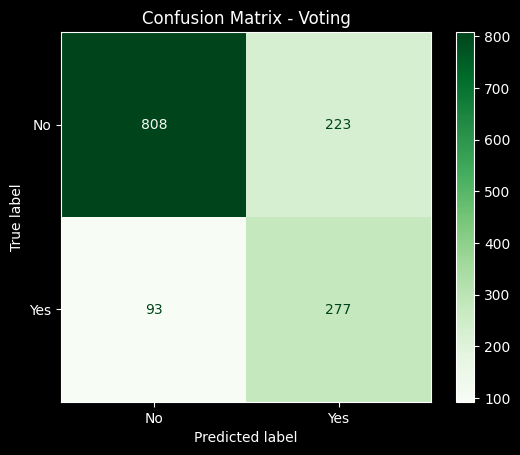

In [34]:
# Prediksi untuk masing-masing model
y_pred_lr_best = lr_pipe_best.predict(X_test)
y_pred_rf_best = rf_pipe_best.predict(X_test)
y_pred_voting_best = voting_pipe_best.predict(X_test)

# Evaluasi Logistic Regression
print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr_best, target_names=['No', 'Yes']))

cm_lr_best = confusion_matrix(y_test, y_pred_lr_best)
ConfusionMatrixDisplay(cm_lr_best, display_labels=['No', 'Yes']).plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Evaluasi Random Forest
print("===== Random Forest =====")
print(classification_report(y_test, y_pred_rf_best, target_names=['No', 'Yes']))

cm_rf_best = confusion_matrix(y_test, y_pred_rf_best)
ConfusionMatrixDisplay(cm_rf_best, display_labels=['No', 'Yes']).plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Evaluasi Voting
print("===== Voting =====")
print(classification_report(y_test, y_pred_voting_best, target_names=['No', 'Yes']))

cm_voting_best = confusion_matrix(y_test, y_pred_voting_best)
ConfusionMatrixDisplay(cm_voting_best, display_labels=['No', 'Yes']).plot(cmap='Greens')
plt.title("Confusion Matrix - Voting")
plt.show()

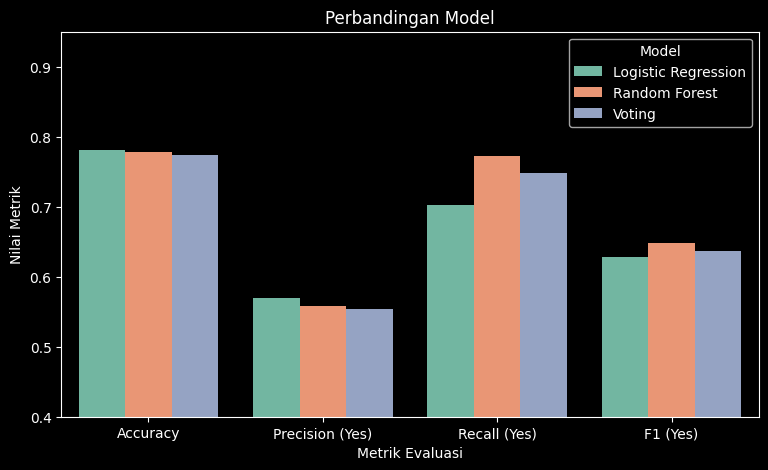

In [35]:
# Hitung metrik utama untuk Logistic Regression
acc_lr_best = accuracy_score(y_test, y_pred_lr_best)
prec_lr_best = precision_score(y_test, y_pred_lr_best, pos_label=1)
recall_lr_best = recall_score(y_test, y_pred_lr_best, pos_label=1)
f1_lr_best = f1_score(y_test, y_pred_lr_best, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_rf_best = accuracy_score(y_test, y_pred_rf_best)
prec_rf_best = precision_score(y_test, y_pred_rf_best, pos_label=1)
recall_rf_best = recall_score(y_test, y_pred_rf_best, pos_label=1)
f1_rf_best = f1_score(y_test, y_pred_rf_best, pos_label=1)

# Hitung metrik utama untuk Random Forest
acc_voting_best = accuracy_score(y_test, y_pred_voting_best)
prec_voting_best = precision_score(y_test, y_pred_voting_best, pos_label=1)
recall_voting_best = recall_score(y_test, y_pred_voting_best, pos_label=1)
f1_voting_best = f1_score(y_test, y_pred_voting_best, pos_label=1)

# Buat DataFrame perbandingan metrik
df_best = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Voting'],
    'Accuracy': [acc_lr_best, acc_rf_best, acc_voting_best],
    'Precision (Yes)': [prec_lr_best, prec_rf_best, prec_voting_best],
    'Recall (Yes)': [recall_lr_best, recall_rf_best, recall_voting_best],
    'F1 (Yes)': [f1_lr_best, f1_rf_best, f1_voting_best]
})

# Ubah format ke long untuk visualisasi seaborn
best_melt = df_best.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=best_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Perbandingan Model')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

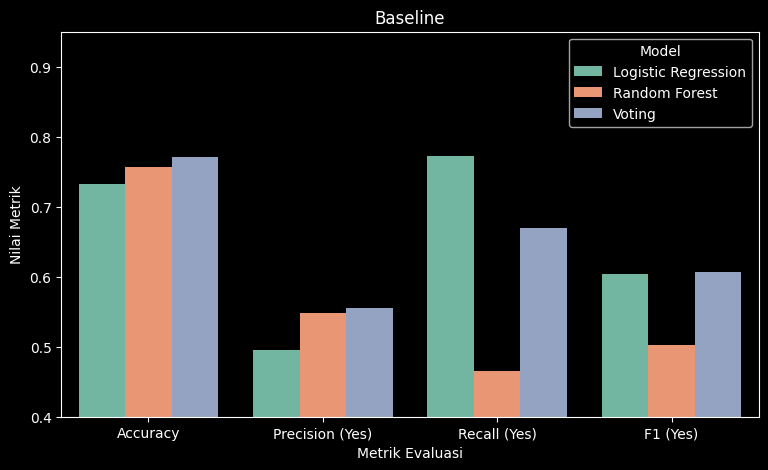

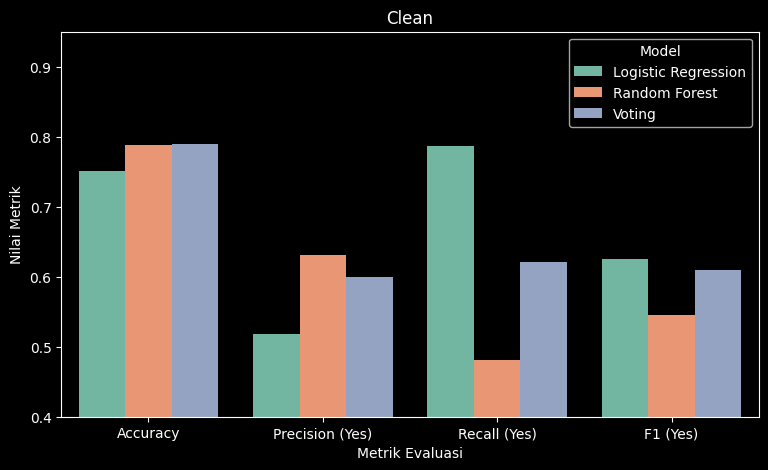

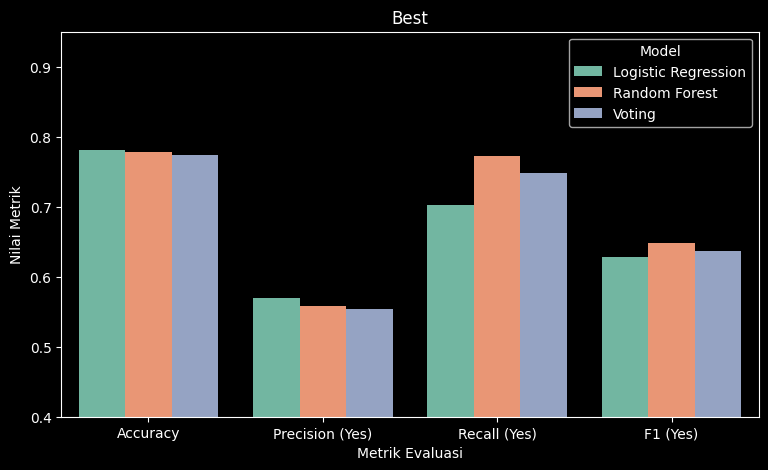

In [36]:
# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=baseline_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Baseline')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=clean_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Clean')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

# Plot perbandingan
plt.figure(figsize=(9,5))
sns.barplot(data=best_melt, x='Metric', y='Score', hue='Model', palette='Set2')
plt.title('Best')
plt.ylim(0.4, 0.95)
plt.ylabel('Nilai Metrik')
plt.xlabel('Metrik Evaluasi')
plt.legend(title='Model', loc='upper right')
plt.show()

In [37]:
oof_probs = np.zeros(len(X_train))
oof_true = y_train.values

for train_idx, val_idx in rkf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = clone(rf_pipe_best)
    model.fit(X_tr, y_tr)

    oof_probs[val_idx] = model.predict_proba(X_val)[:, 1]

In [38]:
thresholds = np.linspace(0.1, 0.9, 8001)
f1_scores = []

for t in thresholds:
    y_pred = (oof_probs >= t).astype(int)
    f1_scores.append(f1_score(oof_true, y_pred))

best_threshold_f1 = thresholds[np.argmax(f1_scores)]

Best Threshold (F1): 0.5085000000000001
Best OOF F1: 0.6345335979586051


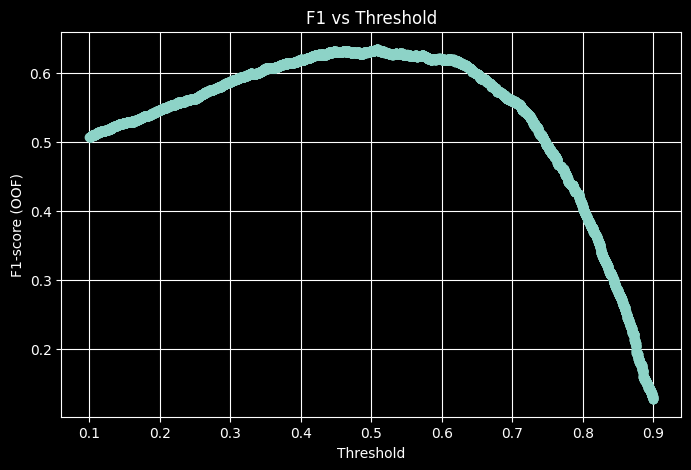

In [39]:
print("Best Threshold (F1):", best_threshold_f1)
print("Best OOF F1:", max(f1_scores))

plt.figure(figsize=(8,5))
plt.plot(thresholds, f1_scores, marker='o')
plt.xlabel("Threshold")
plt.ylabel("F1-score (OOF)")
plt.title("F1 vs Threshold")
plt.grid(True)
plt.show()

In [40]:
final_model = clone(rf_pipe_best)
final_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('feature_selection', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

===== Random Forest =====
              precision    recall  f1-score   support

          No       0.90      0.79      0.84      1031
         Yes       0.56      0.76      0.65       370

    accuracy                           0.78      1401
   macro avg       0.73      0.78      0.74      1401
weighted avg       0.81      0.78      0.79      1401



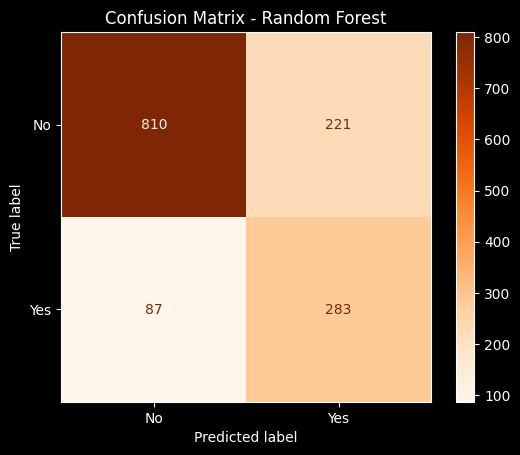

In [41]:
y_test_prob = final_model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= best_threshold_f1).astype(int)

print("===== Random Forest =====")
print(classification_report(y_test, y_test_pred, target_names=['No', 'Yes']))

cm_rf_final = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_rf_final, display_labels=['No', 'Yes']).plot(cmap='Oranges')
plt.title("Confusion Matrix - Random Forest")
plt.show()